In [23]:
import pandas as pd
from gensim import models
import numpy as np
import gensim
import gensim.downloader
from tqdm import tqdm
import time
import os
from matplotlib import pyplot as plt

## Dataset

In [2]:
df_train = pd.read_csv('data/sentiment_treebank/train.csv')
df_eval = pd.read_csv('data/sentiment_treebank/eval.csv')

In [3]:
train_sentences = df_train['sentence'].to_list()
train_sentences = [sentence.lower().split() for sentence in train_sentences]
train_labels = df_train['label'].to_list()

eval_sentences = df_train['sentence'].to_list()
eval_sentences = [sentence.lower().split() for sentence in eval_sentences]
eval_labels = df_train['label'].to_list()

In [4]:
max_length = -np.inf
for sentence in train_sentences:
    if len(sentence) > max_length:
        max_length = len(sentence)

for sentence in eval_sentences:
    if len(sentence) > max_length:
        max_length = len(sentence)

In [5]:
max_length

52

## Word Embeddings

In [6]:
root_dir = 'logs/sentiment_analysis'
os.makedirs(root_dir, exist_ok=True)

In [7]:
vector_size = 50
window_size = 5
negative_size = 15
sentence_size = 60

wv_model_file = root_dir + '/' + 'wv_bilstm.pth'

In [8]:
# wv_model = gensim.downloader.load('glove-wiki-gigaword-50')
# wv_model = models.Word2Vec(sentences=sentences, vector_size=vector_size, window=window_size, negative=negative_size).wv
# wv_model = models.Word2Vec(corpus_file='data/corpus.txt', vector_size=vector_size, window=window_size, negative=negative_size).wv

# wv_model.save(wv_model_file)
# del wv_model

In [9]:
def vectorize_sentences(sentences, wv, sentence_size):
    voc = wv.key_to_index.keys()
    unk = wv['<unk>']
    eos = wv['<eos>']
    lengths = []
    for i, sentence in enumerate(sentences):
        lengths.append(len(sentence))
        
        for i, token in enumerate(sentence):
            if token in voc:
                sentence[i] = wv[token]
            else:
                sentence[i] = unk
        
        
        while len(sentence) < sentence_size:
            sentence.append(eos)
        
        
    return sentences, lengths

In [10]:
wv = models.KeyedVectors.load(wv_model_file)

In [11]:
wv.add_vectors(
    ['<unk>', '<eos>'],
    [np.zeros(wv.vector_size), np.ones(wv.vector_size)]
)

## BiLSTM

In [12]:
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
def save_model(model, file_name):
    torch.save(model.state_dict(), file_name)
def load_model(model, file_name):
    return model.load_state_dict(torch.load(file_name))

In [15]:
hidden_size = 256
num_layers = 2
bidirectional = True

batch_size = 128

lr = 0.001
num_epochs = 50


model_file = root_dir + '/' + 'lstm_model_v2.pth'

In [16]:
train_sentences, train_lengths = vectorize_sentences(train_sentences, wv, sentence_size)
train_sentences = np.array(train_sentences)
train_sentences = torch.tensor(train_sentences, dtype=torch.float)

train_lengths = torch.tensor(train_lengths, dtype=torch.int)
train_labels = torch.tensor(train_labels, dtype=torch.long)


eval_sentences, eval_lengths = vectorize_sentences(eval_sentences, wv, sentence_size)
eval_sentences = np.array(eval_sentences)
eval_sentences = torch.tensor(eval_sentences, dtype=torch.float)

eval_lengths = torch.tensor(eval_lengths, dtype=torch.int)
eval_labels = torch.tensor(eval_labels, dtype=torch.long)

In [17]:
train_loader = torch.utils.data.DataLoader(list(zip(train_sentences, train_lengths, train_labels)), batch_size, shuffle=True)

eval_loader = torch.utils.data.DataLoader(list(zip(eval_sentences, eval_lengths, eval_labels)), batch_size, shuffle=True)

In [18]:
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        lstm_dim = hidden_size * 2 * (2 if bidirectional else 1)
        
        
        self.lstm = nn.LSTM(input_size=vector_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              bidirectional=bidirectional,
                              batch_first=True
                             )
        self.dropout = nn.Dropout(p=0.5)

        
        self.fcnn_1 = nn.Linear(in_features=lstm_dim, out_features=64)
        
        self.fcnn_2 = nn.Linear(in_features=64, out_features=2)
        
        
    def forward(self, sentences, lengths):
        sentences = pack_padded_sequence(sentences, lengths.cpu(), batch_first=True, enforce_sorted=False)
        h_lstm, _ = self.lstm(sentences)
        output, _ = pad_packed_sequence(h_lstm, batch_first=True)
        
        avg_pool = torch.mean(output, 1)
        max_pool, _ = torch.max(output, 1)
        
        
        output = torch.cat([avg_pool, max_pool], 1)
        output = self.dropout(output)
        
        output = self.fcnn_1(output)
        output = torch.relu(output)
        
        output = self.fcnn_2(output)
        
        return output

In [19]:
classifier = Classifier().to(device)

In [20]:
# weights = 1/(train_y.sum(dim=0) / train_y.sum())
# weights = weights.detach().to(device)
# weights

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

In [22]:
min_loss = np.inf

global_train_losses = []
global_eval_losses = []

for i in range(num_epochs):
    print(f'---> Epoch {i} <---')
    time.sleep(0.5)
    
    classifier.train()
    loader = tqdm(train_loader, postfix={'Epoch': i})
    train_losses = []
    
    for sentences, lengths, targets in loader:
        sentences = sentences.to(device)
        targets = targets.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        
        outputs = classifier(sentences, lengths)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            train_losses.append(loss.item())
            loader.set_postfix({
                'Epoch': i,
                'Train loss': np.mean(train_losses)
            }, refresh=True)
    
    global_train_losses.append(np.mean(train_losses))
    
    time.sleep(0.5)
    
    with torch.no_grad():
        classifier.eval()
        loader = tqdm(eval_loader, postfix={'Epoch': i,}, colour='green')
        eval_losses = []
        eval_scores = []

        for sentences, lengths, targets in loader:
            sentences = sentences.to(device)
            targets = targets.to(device)
            lengths = lengths.to(device)

            outputs = classifier(sentences, lengths)
            loss = criterion(outputs, targets)
            
            score = (outputs.argmax(dim=1) == targets).detach().cpu().numpy()
            eval_scores.append(score)
            eval_losses.append(loss.item())
            loader.set_postfix({
                'Epoch': i,
                'Eval loss': np.mean(eval_losses),
                'Eval score': np.concatenate(eval_scores).mean()
            }, refresh=True)


        eval_loss = np.mean(eval_losses)
        if eval_loss <= min_loss:
            min_loss = eval_loss
            save_model(classifier, model_file)
            loader.write('*** save ***')
        
    global_eval_losses.append(np.mean(eval_losses))
    
    time.sleep(0.5)

---> Epoch 0 <---


100%|██████████| 52/52 [00:00<00:00, 79.46it/s, Epoch=0, Eval loss=0.556, Eval score=0.729]


*** save ***
---> Epoch 1 <---


100%|██████████| 52/52 [00:00<00:00, 77.03it/s, Epoch=1, Eval loss=0.507, Eval score=0.766]


*** save ***
---> Epoch 2 <---


100%|██████████| 52/52 [00:00<00:00, 78.43it/s, Epoch=2, Eval loss=0.484, Eval score=0.769]


*** save ***
---> Epoch 3 <---


100%|██████████| 52/52 [00:00<00:00, 80.16it/s, Epoch=3, Eval loss=0.448, Eval score=0.786]


*** save ***
---> Epoch 4 <---


100%|██████████| 52/52 [00:00<00:00, 77.02it/s, Epoch=4, Eval loss=0.424, Eval score=0.801]


*** save ***
---> Epoch 5 <---


100%|██████████| 52/52 [00:00<00:00, 88.95it/s, Epoch=5, Eval loss=0.422, Eval score=0.802]


*** save ***
---> Epoch 6 <---


100%|██████████| 52/52 [00:00<00:00, 79.32it/s, Epoch=6, Eval loss=0.372, Eval score=0.836]


*** save ***
---> Epoch 7 <---


100%|██████████| 52/52 [00:00<00:00, 78.06it/s, Epoch=7, Eval loss=0.355, Eval score=0.845]


*** save ***
---> Epoch 8 <---


100%|██████████| 52/52 [00:00<00:00, 81.05it/s, Epoch=8, Eval loss=0.351, Eval score=0.842]


*** save ***
---> Epoch 9 <---


100%|██████████| 52/52 [00:00<00:00, 78.16it/s, Epoch=9, Eval loss=0.335, Eval score=0.851]


*** save ***
---> Epoch 10 <---


100%|██████████| 52/52 [00:00<00:00, 79.86it/s, Epoch=10, Eval loss=0.251, Eval score=0.899]


*** save ***
---> Epoch 11 <---


100%|██████████| 52/52 [00:00<00:00, 79.97it/s, Epoch=11, Eval loss=0.232, Eval score=0.903]


*** save ***
---> Epoch 12 <---


100%|██████████| 52/52 [00:00<00:00, 79.71it/s, Epoch=12, Eval loss=0.177, Eval score=0.935]


*** save ***
---> Epoch 13 <---


100%|██████████| 52/52 [00:00<00:00, 79.44it/s, Epoch=13, Eval loss=0.145, Eval score=0.951]


*** save ***
---> Epoch 14 <---


100%|██████████| 52/52 [00:00<00:00, 78.14it/s, Epoch=14, Eval loss=0.139, Eval score=0.944]


*** save ***
---> Epoch 15 <---


100%|██████████| 52/52 [00:00<00:00, 77.23it/s, Epoch=15, Eval loss=0.152, Eval score=0.937]


---> Epoch 16 <---


100%|██████████| 52/52 [00:00<00:00, 78.23it/s, Epoch=16, Eval loss=0.0865, Eval score=0.966]


*** save ***
---> Epoch 17 <---


100%|██████████| 52/52 [00:00<00:00, 78.51it/s, Epoch=17, Eval loss=0.0588, Eval score=0.981]


*** save ***
---> Epoch 18 <---


100%|██████████| 52/52 [00:00<00:00, 76.37it/s, Epoch=18, Eval loss=0.0569, Eval score=0.982]


*** save ***
---> Epoch 19 <---


100%|██████████| 52/52 [00:00<00:00, 77.13it/s, Epoch=19, Eval loss=0.06, Eval score=0.982]  


---> Epoch 20 <---


100%|██████████| 52/52 [00:00<00:00, 77.39it/s, Epoch=20, Eval loss=0.0382, Eval score=0.989]


*** save ***
---> Epoch 21 <---


100%|██████████| 52/52 [00:00<00:00, 79.40it/s, Epoch=21, Eval loss=0.0295, Eval score=0.99] 


*** save ***
---> Epoch 22 <---


100%|██████████| 52/52 [00:00<00:00, 79.48it/s, Epoch=22, Eval loss=0.0302, Eval score=0.989]


---> Epoch 23 <---


100%|██████████| 52/52 [00:00<00:00, 77.19it/s, Epoch=23, Eval loss=0.024, Eval score=0.994] 


*** save ***
---> Epoch 24 <---


100%|██████████| 52/52 [00:00<00:00, 75.97it/s, Epoch=24, Eval loss=0.0164, Eval score=0.995]


*** save ***
---> Epoch 25 <---


100%|██████████| 52/52 [00:00<00:00, 76.66it/s, Epoch=25, Eval loss=0.0268, Eval score=0.99] 


---> Epoch 26 <---


100%|██████████| 52/52 [00:00<00:00, 77.35it/s, Epoch=26, Eval loss=0.0344, Eval score=0.988]


---> Epoch 27 <---


100%|██████████| 52/52 [00:00<00:00, 77.04it/s, Epoch=27, Eval loss=0.0133, Eval score=0.997]


*** save ***
---> Epoch 28 <---


100%|██████████| 52/52 [00:00<00:00, 76.97it/s, Epoch=28, Eval loss=0.0092, Eval score=0.997] 


*** save ***
---> Epoch 29 <---


100%|██████████| 52/52 [00:00<00:00, 78.66it/s, Epoch=29, Eval loss=0.00576, Eval score=0.999]


*** save ***
---> Epoch 30 <---


100%|██████████| 52/52 [00:00<00:00, 78.49it/s, Epoch=30, Eval loss=0.0232, Eval score=0.993]


---> Epoch 31 <---


100%|██████████| 52/52 [00:00<00:00, 77.53it/s, Epoch=31, Eval loss=0.0134, Eval score=0.997]


---> Epoch 32 <---


100%|██████████| 52/52 [00:00<00:00, 76.94it/s, Epoch=32, Eval loss=0.0045, Eval score=0.999] 


*** save ***
---> Epoch 33 <---


100%|██████████| 52/52 [00:00<00:00, 77.81it/s, Epoch=33, Eval loss=0.00544, Eval score=0.998]


---> Epoch 34 <---


100%|██████████| 52/52 [00:00<00:00, 85.80it/s, Epoch=34, Eval loss=0.0149, Eval score=0.996]


---> Epoch 35 <---


100%|██████████| 52/52 [00:00<00:00, 79.69it/s, Epoch=35, Eval loss=0.00377, Eval score=0.999]


*** save ***
---> Epoch 36 <---


100%|██████████| 52/52 [00:00<00:00, 78.93it/s, Epoch=36, Eval loss=0.00446, Eval score=0.999]


---> Epoch 37 <---


100%|██████████| 52/52 [00:00<00:00, 78.39it/s, Epoch=37, Eval loss=0.0314, Eval score=0.991]


---> Epoch 38 <---


100%|██████████| 52/52 [00:00<00:00, 78.37it/s, Epoch=38, Eval loss=0.0285, Eval score=0.991]


---> Epoch 39 <---


100%|██████████| 52/52 [00:00<00:00, 79.63it/s, Epoch=39, Eval loss=0.00735, Eval score=0.998]


---> Epoch 40 <---


100%|██████████| 52/52 [00:00<00:00, 78.30it/s, Epoch=40, Eval loss=0.00513, Eval score=0.999]


---> Epoch 41 <---


100%|██████████| 52/52 [00:00<00:00, 79.92it/s, Epoch=41, Eval loss=0.00248, Eval score=0.999]


*** save ***
---> Epoch 42 <---


100%|██████████| 52/52 [00:00<00:00, 79.69it/s, Epoch=42, Eval loss=0.00323, Eval score=0.999]


---> Epoch 43 <---


100%|██████████| 52/52 [00:00<00:00, 77.99it/s, Epoch=43, Eval loss=0.00702, Eval score=0.998]


---> Epoch 44 <---


100%|██████████| 52/52 [00:00<00:00, 77.85it/s, Epoch=44, Eval loss=0.00283, Eval score=0.999]


---> Epoch 45 <---


100%|██████████| 52/52 [00:00<00:00, 77.07it/s, Epoch=45, Eval loss=0.0091, Eval score=0.997] 


---> Epoch 46 <---


100%|██████████| 52/52 [00:00<00:00, 78.33it/s, Epoch=46, Eval loss=0.0306, Eval score=0.988]


---> Epoch 47 <---


100%|██████████| 52/52 [00:00<00:00, 76.67it/s, Epoch=47, Eval loss=0.00731, Eval score=0.998]


---> Epoch 48 <---


100%|██████████| 52/52 [00:00<00:00, 77.66it/s, Epoch=48, Eval loss=0.00361, Eval score=0.999]


---> Epoch 49 <---


100%|██████████| 52/52 [00:00<00:00, 82.02it/s, Epoch=49, Eval loss=0.00603, Eval score=0.998]


### Plots

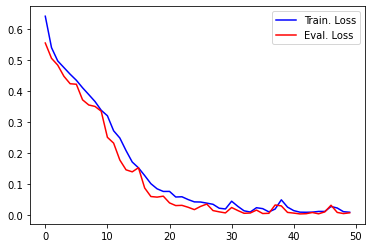

In [27]:
plt.plot(range(num_epochs), global_train_losses, label='Train. Loss', color='blue')
plt.plot(range(num_epochs), global_eval_losses, label='Eval. Loss', color='red')

plt.legend()
plt.show()